# matched filter upsampling

If we're dealing with a narrowband signal, we can use FFT resampling to interpolate the signal value at times between the sample instances. This exercise shows how to find the upsampled results from the matched filter outputs of a SDR data capture

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import argparse
import scipy.signal as sig

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12

# plot the matched filter outputs captured by 2 different base stations
# use time as the X axis
def compareMF(file1, file2, outfile=None, index=True, mag=True):
    f1 = np.load(file1)
    f2 = np.load(file2)
    if index:
        t = np.arange(f1['data'].size)
    else:
        t = f1['t0'] + np.arange(f1['data'].size)*f1['Ts']
    plt.figure()
    if mag:
        plt.plot(t, np.abs(f1['data']), "C0-", label="gw1")
        plt.plot(t, np.abs(f2['data']), "C1-", label="gw2")
    else:
        plt.plot(t, f1['data'].real, "C0-", label="r1")
        plt.plot(t, f1['data'].imag, "C1-", label="i1")
        plt.plot(t, f2['data'].real, "C2-", label="r2")
        plt.plot(t, f2['data'].imag, "C3-", label="i2")
    if index:
        plt.xlabel("index")
    else:
        plt.xlabel("time (s)")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, format='pdf')
        
# plot the matched filter outputs between two sample indices captured by 2 different base stations
# uses sample index as X axis
def compareMFIndex(file1, file2, start, stop, outfile=None, index=True, mag=True):
    f1 = np.load(file1)
    f2 = np.load(file2)
    if index:
        t = np.arange(start, stop)
    else:
        t = f1['t0'] + np.arange(start, stop)*f1['Ts']
    plt.figure()
    if mag:
        plt.plot(t, np.abs(f1['data'][start:stop]), "C0-", label="gw1")
        plt.plot(t, np.abs(f2['data'][start:stop]), "C1-", label="gw2")
    else:
        plt.plot(t, f1['data'][start:stop].real, "C0-", label="r1")
        plt.plot(t, f1['data'][start:stop].imag, "C1-", label="i1")
        plt.plot(t, f2['data'][start:stop].real, "C2-", label="r2")
        plt.plot(t, f2['data'][start:stop].imag, "C3-", label="i2")
    if index:
        plt.xlabel("index")
    else:
        plt.xlabel("time (s)")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, format='pdf')
        
def compareUpsampled(file1, file2, center, upFactor, width=2, window=1024, outfile=None, mag=True):
    def selectiveUpsample(data, center, upFactor, width=2, window=1024):
        wstart = int(center - window/2)
        wend = int(center + window/2)
        dstart = int(center - width/2)
        dend = int(center + width/2)

        idat = np.arange(wstart, wend)  # indices of original data 
        iup = np.arange(dstart, dend, 1/upFactor)  # new indices to use for upsampled version
        idiff = np.reshape(iup, (-1, 1)) - np.reshape(idat, (1, -1))  # differences in indices
        result = np.dot(np.sinc(idiff), data[wstart:wend])
        return result, iup
    
    f1 = np.load(file1)
    f2 = np.load(file2)
    
    print("data sampling rates: ", f1['Ts'], f2['Ts'])
    
    wstart = int(center - window/2)
    wend = int(center + window/2)
    dstart = int(center - width/2)
    dend = int(center + width/2)
    t = np.arange(dstart, dend)
        
    up1, tup1 = selectiveUpsample(f1['data'], center, upFactor, width, window)
    up2, tup2 = selectiveUpsample(f2['data'], center, upFactor, width, window)
    
    # find peak location
    argmaxup1 = np.argmax(np.abs(up1))
    argmaxup2 = np.argmax(np.abs(up2))
    print("sig 1 max {} at {}".format(np.abs(up1[argmaxup1]), tup1[argmaxup1]))
    print("sig 2 max {} at {}".format(np.abs(up2[argmaxup2]), tup2[argmaxup2]))
    print("time diff = {}".format(tup1[argmaxup1] - tup2[argmaxup2]))
    
    
    plt.figure()
    if mag:
        plt.plot(tup1, np.abs(up1), "C0-")
        plt.plot(t, np.abs(f1['data'][dstart:dend]), "C0.", label="gw1")
        plt.plot(tup2, np.abs(up2), "C1-")
        plt.plot(t, np.abs(f2['data'][dstart:dend]), "C1.", label="gw2")
    else:
        plt.plot(tup1, up1.real, "C0-")
        plt.plot(tup1, up1.imag, "C1-")
        plt.plot(t, f1['data'][dstart:dend].real, "C0.", label="real(gw1)")
        plt.plot(t, f1['data'][dstart:dend].imag, "C1.", label="imag(gw1)")
        plt.plot(tup2, up2.real, "C2-")
        plt.plot(tup2, up2.imag, "C3-")
        plt.plot(t, f2['data'][dstart:dend].real, "C2.", label="real(gw2)")
        plt.plot(t, f2['data'][dstart:dend].imag, "C3.", label="imag(gw2)")

    plt.xlabel("sample index ($T_s$ = {:.2f} $\mu$ s)".format(np.round(f1['Ts']*1e6, 2)))
    plt.ylabel("magnitude")
    plt.grid()
    plt.legend(fontsize='x-small', loc='upper right')
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, format='pdf')


<IPython.core.display.Javascript object>


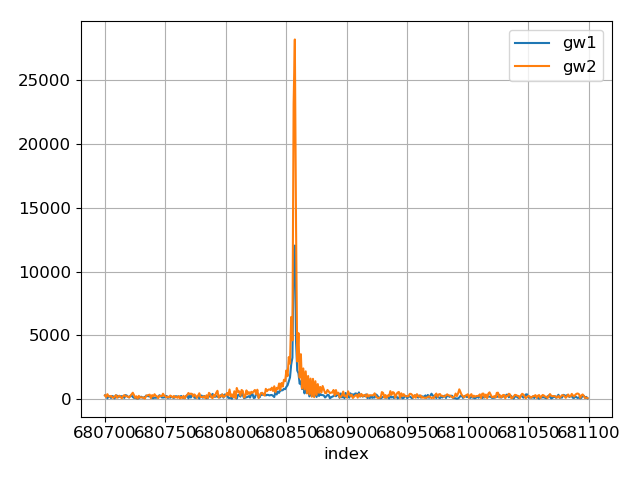

data sampling rates:  3.99999360001024e-06 3.99999360001024e-06
sig 1 max 12895.135312227567 at 680856.5600000145
sig 2 max 29041.756952166783 at 680856.7300000146
time diff = -0.17000000015832484


<IPython.core.display.Javascript object>


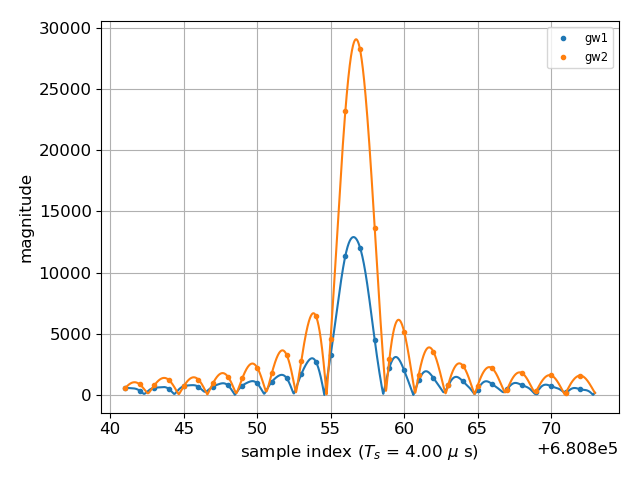

In [2]:
# scott position 1 904
fileegg = '/media/adwait/44EE36CDEE36B6D0/workspace/sdr_data/matchedfilter/outdoor_13june/eggtart/mf_exp1_904.750M_2020-06-13_17-41-05.000.dat.npz'
filebanana = '/media/adwait/44EE36CDEE36B6D0/workspace/sdr_data/matchedfilter/outdoor_13june/bananacream/mf_exp1_904.750M_2020-06-13_17-41-05.000.dat.npz'

# view the entire captured waveform output
# compareMF(fileegg, filebanana)

# onl view the output in a certain interval, given by sample indices
compareMFIndex(fileegg, filebanana, 680700, 681100)

# use this format to generate output in an interval (specified by indices) and display it but dont save it
compareUpsampled(fileegg, filebanana, 680857, 100, width=32, window=1024, outfile=None, mag=True)

# use this format to save output in file
# compareUpsampled(fileegg, filebanana, 680857, 100, width=32, window=1024, outfile="results/scott1_904.pdf", mag=True)


plt.show()